In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [4]:

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),  # Normalize to [0,1]
])

## Step 1: Define the Dataset Loader

In [28]:

class CloudDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_filenames = sorted(os.listdir(image_dir))
        self.mask_filenames = sorted(os.listdir(mask_dir))
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_filenames[idx])

        image = Image.open(image_path).convert("L")  # Grayscale
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

#### Define Transformations

#### Load Dataset

In [5]:
image_dir = "satelite_images/Cloud_cover"
mask_dir = "satelite_images/Masks_old"
dataset = CloudDataset(image_dir, mask_dir, transform=transform)

## Step 2: Define LightCSPNet Model

In [29]:
class LightCSPNet(nn.Module):
    def __init__(self):
        super(LightCSPNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 1, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)
        self.upsample = nn.Upsample(scale_factor=4, mode='bilinear', align_corners=True)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = self.upsample(self.conv4(x))  # no activation
        return x

# Step 3: Train the Model

In [32]:
image_dir = "satelite_images/Cloud_cover"
mask_dir = "satelite_images/Masks_old"

dataset = CloudDataset(image_dir, mask_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LightCSPNet().to(device)

criterion = nn.BCEWithLogitsLoss()  # Stable, no need for sigmoid
optimizer = optim.Adam(model.parameters(), lr=0.0005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

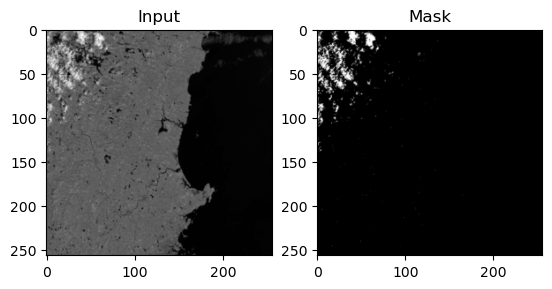

In [35]:
import matplotlib.pyplot as plt

sample_img, sample_mask = next(iter(dataloader))
plt.subplot(1, 2, 1)
plt.imshow(sample_img[0][0].cpu(), cmap='gray')
plt.title("Input")
plt.subplot(1, 2, 2)
plt.imshow(sample_mask[0][0].cpu(), cmap='gray')
plt.title("Mask")
plt.show()

In [34]:
# Training loop
epochs = 60
model.train()

for epoch in range(epochs):
    total_loss = 0.0

    for images, masks in dataloader:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        # Ensure masks and outputs match in shape
        outputs = F.interpolate(outputs, size=masks.shape[2:], mode="bilinear", align_corners=False)

        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")
    scheduler.step()

Epoch 1/60, Loss: 1.4931
Epoch 2/60, Loss: 1.4804
Epoch 3/60, Loss: 1.4733
Epoch 4/60, Loss: 1.4625
Epoch 5/60, Loss: 1.4508
Epoch 6/60, Loss: 1.4442
Epoch 7/60, Loss: 1.4397
Epoch 8/60, Loss: 1.4353
Epoch 9/60, Loss: 1.4304
Epoch 10/60, Loss: 1.4256
Epoch 11/60, Loss: 1.4225
Epoch 12/60, Loss: 1.4202
Epoch 13/60, Loss: 1.4179
Epoch 14/60, Loss: 1.4155
Epoch 15/60, Loss: 1.4133
Epoch 16/60, Loss: 1.4115
Epoch 17/60, Loss: 1.4103
Epoch 18/60, Loss: 1.4094
Epoch 19/60, Loss: 1.4083
Epoch 20/60, Loss: 1.4072
Epoch 21/60, Loss: 1.4062
Epoch 22/60, Loss: 1.4057
Epoch 23/60, Loss: 1.4052
Epoch 24/60, Loss: 1.4047
Epoch 25/60, Loss: 1.4041
Epoch 26/60, Loss: 1.4036
Epoch 27/60, Loss: 1.4033
Epoch 28/60, Loss: 1.4030
Epoch 29/60, Loss: 1.4028
Epoch 30/60, Loss: 1.4025
Epoch 31/60, Loss: 1.4023
Epoch 32/60, Loss: 1.4021
Epoch 33/60, Loss: 1.4020
Epoch 34/60, Loss: 1.4019
Epoch 35/60, Loss: 1.4017
Epoch 36/60, Loss: 1.4016
Epoch 37/60, Loss: 1.4016
Epoch 38/60, Loss: 1.4015
Epoch 39/60, Loss: 1.

#### Save Model

In [36]:

torch.save(model.state_dict(), "lightcspnet_cloudmask.pth")
print("Model training complete and saved as 'lightcspnet_cloudmask.pth'!")

Model training complete and saved as 'lightcspnet_cloudmask.pth'!


# Step 4: Cloud Mask Prediction

In [37]:

def generate_cloud_mask(image_path, model):
    image = Image.open(image_path).convert("L")
    image = image.resize((256, 256))
    image_tensor = transforms.ToTensor()(image).unsqueeze(0)
    
    with torch.no_grad():
        mask_pred = model(image_tensor)
    
    mask_np = (mask_pred.squeeze().numpy() * 255).astype("uint8")
    mask_image = Image.fromarray(mask_np)
    return mask_image

#### Load Trained Model

In [38]:
model.load_state_dict(torch.load("lightcspnet_cloudmask.pth", map_location=torch.device('cpu')))
model.eval()
model.to(device)

C:\Users\flybu\AppData\Local\Temp\ipykernel_23416\1957247737.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("lightcspnet_cloudmask.pth"

LightCSPNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (upsample): Upsample(scale_factor=4.0, mode='bilinear')
)

#### Predict and Save Cloud Mask

In [39]:

image_path = "satelite_images/Cloud_cover/Cloud_1.jpg"
cloud_mask = "satelite_images/Masks_old/mask_Cloud_1.jpg"
predicted_mask = generate_cloud_mask(image_path, model)
predicted_mask.save("predicted_cloud_mask.jpg")
print("Cloud mask generated and saved!")

Cloud mask generated and saved!


In [40]:
# Load the images
original_image = Image.open(image_path)
original_mask = Image.open(cloud_mask)
predicted_mask = Image.open("predicted_cloud_mask.jpg")

# Convert images to arrays for visualization
original_image_np = np.array(original_image)
original_mask_np = np.array(original_mask)
predicted_mask_np = np.array(predicted_mask)



In [41]:
# ==== IoU and Dice Metric ==== #

# Resize original mask to match predicted mask shape
original_mask_np = cv2.resize(original_mask_np, (predicted_mask_np.shape[1], predicted_mask_np.shape[0]))

# Ensure masks are binary (0 and 1)
pred_bin = (predicted_mask_np > 127).astype(np.float32)
target_bin = (original_mask_np > 127).astype(np.float32)

# Compute metrics
intersection = np.logical_and(pred_bin, target_bin).sum()
union = np.logical_or(pred_bin, target_bin).sum()
dice = 2 * intersection / (pred_bin.sum() + target_bin.sum() + 1e-6)
iou = intersection / (union + 1e-6)

# Print results
print(f"IoU Score: {iou:.4f}")
print(f"Dice Score: {dice:.4f}")

IoU Score: 0.0235
Dice Score: 0.0460


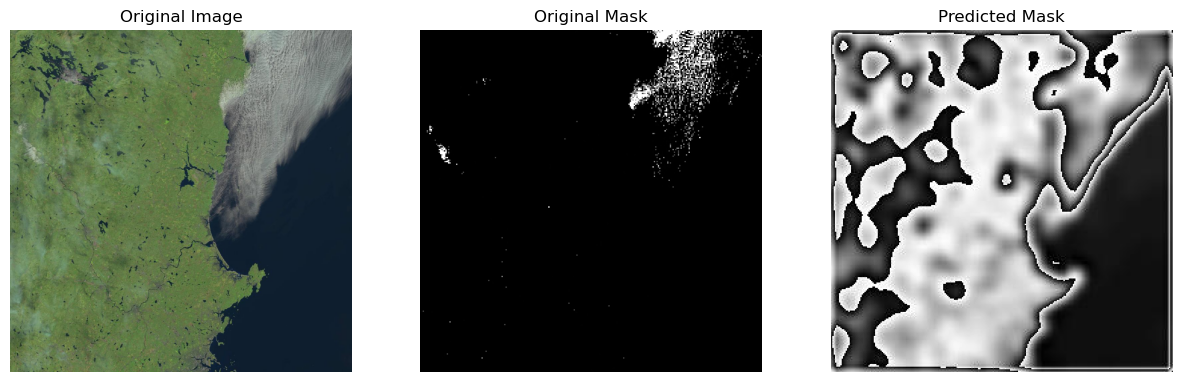

In [42]:
# Plot the images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(original_image_np)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(original_mask_np, cmap="gray")
axes[1].set_title("Original Mask")
axes[1].axis("off")

axes[2].imshow(predicted_mask_np, cmap="gray")
axes[2].set_title("Predicted Mask")
axes[2].axis("off")

plt.show()